# Pop Lyrics

In [172]:
# Imports
import requests
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import plotly.express as px
import spacy
import random

from dotenv import load_dotenv
from collections import Counter
from collections import defaultdict
from PIL import Image
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import ngrams
from spacy import displacy
from nltk.lm import MLE # language model
from nltk import word_tokenize, sent_tokenize
from nltk.util import pad_sequence, bigrams, ngrams, everygrams
from nltk.lm.preprocessing import pad_both_ends, flatten, padded_everygram_pipeline
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [173]:
# Load .env environment variables
load_dotenv()

Set RAPID API key
my_rapid_api_key = os.getenv("RAPID_API_KEY")


True

In [174]:
# Define function to use Shazam Core API

def get_chart_genre(querystring):

    url = "https://shazam-core.p.rapidapi.com/v1/charts/genre-world"

    headers = {
    'x-rapidapi-host': "shazam-core.p.rapidapi.com",
    'x-rapidapi-key': my_rapid_api_key
    }

    response = requests.request("GET", url, headers=headers, params=querystring)

    return response.json()

In [175]:
# Define function to use Shazam Core API

def get_lyrics(querystring):

    url = "https://shazam-core.p.rapidapi.com/v1/tracks/details"

    headers = {
    'x-rapidapi-host': "shazam-core.p.rapidapi.com",
    'x-rapidapi-key': my_rapid_api_key
    }

    response = requests.request("GET", url, headers=headers, params=querystring)

    return response.json()

In [176]:
# Use 'Track details' endpoint to retrieve lyrics for a single track

genre = 'POP'
limit_songs = 50
country = 'US'

querystring = {"country_code":country,"genre_code":genre,"limit":limit_songs}
chart_response = get_chart_genre(querystring)

In [177]:
# Retrieve Track IDs

track_ids=[] # song identifier
titles = [] # song name
subtitles = [] # Main artist and featured artists

for track in range(len(chart_response)):
    track_ids.append(chart_response[track]['id'])
    titles.append(chart_response[track]['title'])
    subtitles.append(chart_response[track]['subtitle'])

print(f"The number of songs retrieved is : {len(track_ids)}")

chart_songs = pd.DataFrame({"Track Name": titles, "Artists": subtitles, 'TrackIDs': track_ids}).set_index('TrackIDs')
chart_songs.head(5)

The number of songs retrieved is : 50


,Track Name,Artists
TrackIDs,,
579595745,Cold Heart (PNAU Remix),Elton John & Dua Lipa
587472945,Easy On Me,Adele
577983490,abcdefu,GAYLE
560551698,I'm Alone,Melisa & Tommo
70596703,Locked Out Of Heaven,Bruno Mars


In [178]:
# Look at the data

# from collections import Counter

artists_list = list(chart_songs.Artists)
artist_counts = {artist: artists_list.count(artist) for artist in artists_list} #dict with frequency of artist in top chart

artists_df = pd.DataFrame(list(artist_counts.items()),columns = ['Artists','No. Songs in Top Chart']).set_index('Artists')
artists_df.sort_values(by = 'No. Songs in Top Chart', ascending=False, inplace=True) #sort values

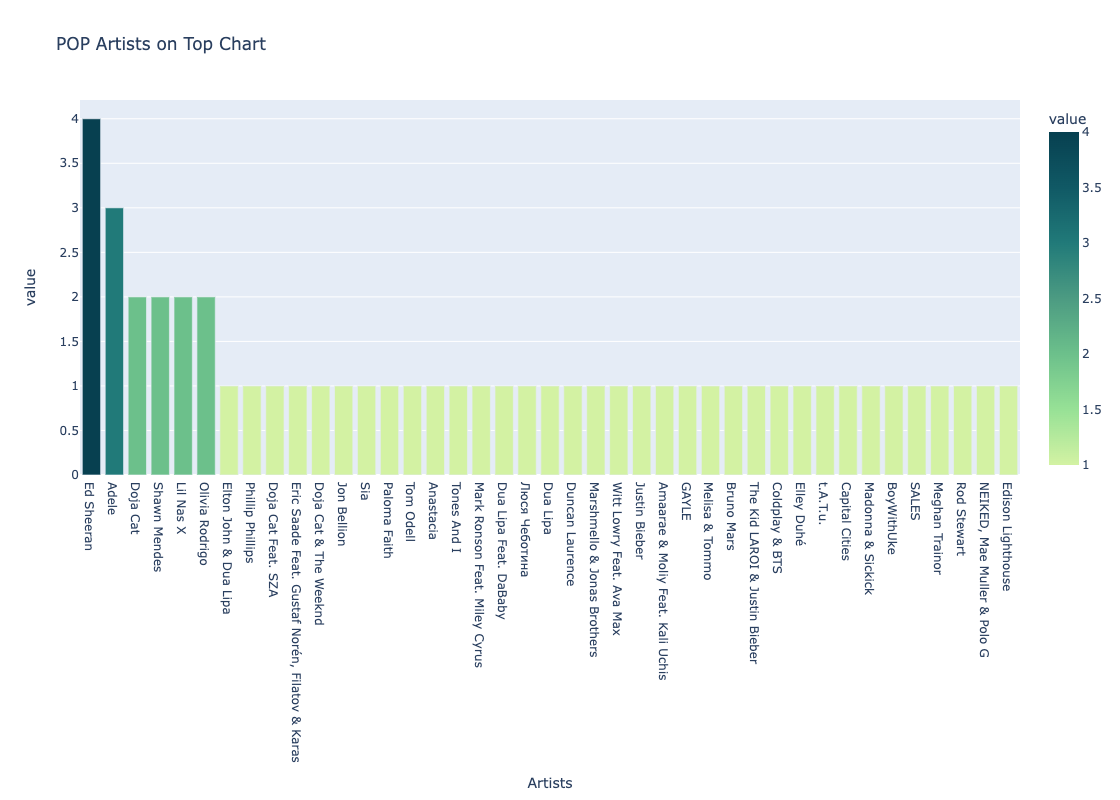

In [179]:
# Visualize data

fig2 = px.bar(
    artists_df,
    color = "value",
    color_continuous_scale='emrld',
    title = 'POP Artists on Top Chart',
    height = 800
)
fig2.show()


In [180]:
# Retrieve Lyrics for all TrackIDs
track_ids 

lyrics=[]

for trackID in track_ids:
    querystring = {"track_id":trackID}
    track_details_response = get_lyrics(querystring)

    if track_details_response['sections'][1]['type'] != "LYRICS":  
        lyrics.append([''])
    else:
        track_lyrics = track_details_response['sections'][1]['text']
        lyrics.append(track_lyrics)

In [181]:
# Add lyrics column to dataframe with chart songs

all_lyrics = pd.Series(" ".join(map(str,song)) for song in lyrics) #each song is stored as a list, this turns each list into a string
all_lyrics_df = pd.DataFrame({"Lyrics": all_lyrics, "Track IDs": track_ids}).set_index('Track IDs')

lyrics_df = pd.concat([chart_songs, all_lyrics_df], axis=1)
lyrics_df.head(5)

,Track Name,Artists,Lyrics
579595745,Cold Heart (PNAU Remix),Elton John & Dua Lipa,It's a human sign When things go wrong When th...
587472945,Easy On Me,Adele,There ain't no gold in this river That I've be...
577983490,abcdefu,GAYLE,Fuck you and your mom and your sister and your...
560551698,I'm Alone,Melisa & Tommo,
70596703,Locked Out Of Heaven,Bruno Mars,"One, two, one, two, three Oh yeah yeah Oh yea..."


In [182]:
lyrics_df

,Track Name,Artists,Lyrics
579595745,Cold Heart (PNAU Remix),Elton John & Dua Lipa,It's a human sign When things go wrong When th...
587472945,Easy On Me,Adele,There ain't no gold in this river That I've be...
577983490,abcdefu,GAYLE,Fuck you and your mom and your sister and your...
560551698,I'm Alone,Melisa & Tommo,
70596703,Locked Out Of Heaven,Bruno Mars,"One, two, one, two, three Oh yeah yeah Oh yea..."
581315745,Shivers,Ed Sheeran,I took an arrow to the heart I never kissed a ...
552221348,Stay,The Kid LAROI & Justin Bieber,I do the same thing I told you that I never wo...
573386652,Bad Habits,Ed Sheeran,"One, two, three, four Ooh, ooh Every time you..."
584558302,My Universe,Coldplay & BTS,"You (you), you are (you are) my universe And I..."
506004198,Middle of the Night,Elley Duhé,"I summoned you, please come to me Don't bury t..."


In [184]:
# Remove songs without lyrics

lyrics_df.drop(lyrics_df.loc[lyrics_df['Lyrics'] == ''].index.tolist(), inplace=True)
lyrics_df.head(30)

,Track Name,Artists,Lyrics
579595745,Cold Heart (PNAU Remix),Elton John & Dua Lipa,It's a human sign When things go wrong When th...
587472945,Easy On Me,Adele,There ain't no gold in this river That I've be...
577983490,abcdefu,GAYLE,Fuck you and your mom and your sister and your...
70596703,Locked Out Of Heaven,Bruno Mars,"One, two, one, two, three Oh yeah yeah Oh yea..."
581315745,Shivers,Ed Sheeran,I took an arrow to the heart I never kissed a ...
552221348,Stay,The Kid LAROI & Justin Bieber,I do the same thing I told you that I never wo...
573386652,Bad Habits,Ed Sheeran,"One, two, three, four Ooh, ooh Every time you..."
584558302,My Universe,Coldplay & BTS,"You (you), you are (you are) my universe And I..."
506004198,Middle of the Night,Elley Duhé,"I summoned you, please come to me Don't bury t..."
584941330,Sad Girlz Luv Money Remix,Amaarae & Moliy Feat. Kali Uchis,"Kali Uchis Oh, there's dollars all around Dol..."


In [252]:
#Remove non english lyrics
new_lyrics_df = lyrics_df.drop(
    [
        '588485896'
    ]
)
new_lyrics_df

,Track Name,Artists,Lyrics
579595745,Cold Heart (PNAU Remix),Elton John & Dua Lipa,It's a human sign When things go wrong When th...
587472945,Easy On Me,Adele,There ain't no gold in this river That I've be...
577983490,abcdefu,GAYLE,Fuck you and your mom and your sister and your...
70596703,Locked Out Of Heaven,Bruno Mars,"One, two, one, two, three Oh yeah yeah Oh yea..."
581315745,Shivers,Ed Sheeran,I took an arrow to the heart I never kissed a ...
552221348,Stay,The Kid LAROI & Justin Bieber,I do the same thing I told you that I never wo...
573386652,Bad Habits,Ed Sheeran,"One, two, three, four Ooh, ooh Every time you..."
584558302,My Universe,Coldplay & BTS,"You (you), you are (you are) my universe And I..."
506004198,Middle of the Night,Elley Duhé,"I summoned you, please come to me Don't bury t..."
584941330,Sad Girlz Luv Money Remix,Amaarae & Moliy Feat. Kali Uchis,"Kali Uchis Oh, there's dollars all around Dol..."


# Tokenizer
In this section, we use NLTK and Python to tokenize the text. This will include:

- Lowercase each word
- Remove Punctuation
- Remove Stopwords

In [253]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

In [254]:
def tokenizer(Lyrics):
    """Tokenizes text."""
    # Create a list of the words
    words_tokened = word_tokenize(Lyrics)

    # Convert the words to lowercase
    words_lowered = [word.lower() for word in words_tokened]

    # Remove the punctuation
    regex = re.compile('[^a-zA-Z]')
    words_regexed = [regex.sub('', word) for word in words_lowered]
    
    # Remove the stop words
    sw = set(stopwords.words('english'))
    sw_add_ons = [ 'christmas', 'fuck', 'doo', '', 'ah', 'ca', 'na', 'Doo', 'doo', 'nt', 'ay', 'wan', 'wo', 'ta', 'oh', 'ohoh', 'cause', 'Romano', 'mistletoe', 'christmas', 'jingle', 'santa', 'dick', 'Hitmaka', 'fuckin', "fuckin'", 'fuck', 'shit', 'nigga', 'niggas', 'bitch', 'motherfucker', 'Motherfucker', 'dick']
    stopwords_removed = [word.lower() for word in words_regexed if word not in sw.union(sw_add_ons)]

    # Lemmatize Words into root words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in stopwords_removed]

    return tokens

In [255]:
# Create a new tokens column for lyrics
lyrics_tokens = [tokenizer(words) for words in new_lyrics_df['Lyrics']]
new_lyrics_df['Tokens'] = lyrics_tokens
new_lyrics_df.head()

,Track Name,Artists,Lyrics,Tokens
579595745,Cold Heart (PNAU Remix),Elton John & Dua Lipa,It's a human sign When things go wrong When th...,"[human, sign, thing, go, wrong, scent, lingers..."
587472945,Easy On Me,Adele,There ain't no gold in this river That I've be...,"[ai, gold, river, washing, hand, forever, know..."
577983490,abcdefu,GAYLE,Fuck you and your mom and your sister and your...,"[mom, sister, job, brokeass, car, call, art, f..."
70596703,Locked Out Of Heaven,Bruno Mars,"One, two, one, two, three Oh yeah yeah Oh yea...","[one, two, one, two, three, yeah, yeah, yeah, ..."
581315745,Shivers,Ed Sheeran,I took an arrow to the heart I never kissed a ...,"[took, arrow, heart, never, kissed, mouth, tas..."


In [258]:
new_lyrics_df.reset_index(inplace=True)
new_lyrics_df

,index,Track Name,Artists,Lyrics,Tokens
0,579595745,Cold Heart (PNAU Remix),Elton John & Dua Lipa,It's a human sign When things go wrong When th...,"[human, sign, thing, go, wrong, scent, lingers..."
1,587472945,Easy On Me,Adele,There ain't no gold in this river That I've be...,"[ai, gold, river, washing, hand, forever, know..."
2,577983490,abcdefu,GAYLE,Fuck you and your mom and your sister and your...,"[mom, sister, job, brokeass, car, call, art, f..."
3,70596703,Locked Out Of Heaven,Bruno Mars,"One, two, one, two, three Oh yeah yeah Oh yea...","[one, two, one, two, three, yeah, yeah, yeah, ..."
4,581315745,Shivers,Ed Sheeran,I took an arrow to the heart I never kissed a ...,"[took, arrow, heart, never, kissed, mouth, tas..."
5,552221348,Stay,The Kid LAROI & Justin Bieber,I do the same thing I told you that I never wo...,"[thing, told, never, would, told, change, even..."
6,573386652,Bad Habits,Ed Sheeran,"One, two, three, four Ooh, ooh Every time you...","[one, two, three, four, ooh, ooh, every, time,..."
7,584558302,My Universe,Coldplay & BTS,"You (you), you are (you are) my universe And I...","[universe, want, want, put, first, universe, n..."
8,506004198,Middle of the Night,Elley Duhé,"I summoned you, please come to me Don't bury t...","[summoned, please, come, bury, thought, really..."
9,584941330,Sad Girlz Luv Money Remix,Amaarae & Moliy Feat. Kali Uchis,"Kali Uchis Oh, there's dollars all around Dol...","[kali, uchis, dollar, around, dollar, dollar, ..."


In [259]:
new_lyrics_df[['Lyrics', 'Tokens']]

,Lyrics,Tokens
0,It's a human sign When things go wrong When th...,"[human, sign, thing, go, wrong, scent, lingers..."
1,There ain't no gold in this river That I've be...,"[ai, gold, river, washing, hand, forever, know..."
2,Fuck you and your mom and your sister and your...,"[mom, sister, job, brokeass, car, call, art, f..."
3,"One, two, one, two, three Oh yeah yeah Oh yea...","[one, two, one, two, three, yeah, yeah, yeah, ..."
4,I took an arrow to the heart I never kissed a ...,"[took, arrow, heart, never, kissed, mouth, tas..."
5,I do the same thing I told you that I never wo...,"[thing, told, never, would, told, change, even..."
6,"One, two, three, four Ooh, ooh Every time you...","[one, two, three, four, ooh, ooh, every, time,..."
7,"You (you), you are (you are) my universe And I...","[universe, want, want, put, first, universe, n..."
8,"I summoned you, please come to me Don't bury t...","[summoned, please, come, bury, thought, really..."
9,"Kali Uchis Oh, there's dollars all around Dol...","[kali, uchis, dollar, around, dollar, dollar, ..."


# Calculating VADER Sentiment Score for LYRICS

As you know the `compound` score could be used to get a normalized score for a sentiment. We create a function called `get_sentiment(score)` that will return a normalized value of sentiment for the `score` parameter based on the rules. This function should return `1` for positive sentiment, `-1` for negative sentiment, and `0` for neutral sentiment.

In [260]:
# Download/Update the VADER Lexicon
nltk.download("vader_lexicon")

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/moniqueferguson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [261]:
# Sentiment calculation based on compound score
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

In [262]:
# Sentiment scores dictionaries
lyrics_sent = {
    "lyrics_compound": [],
    "lyrics_pos": [],
    "lyrics_neu": [],
    "lyrics_neg": [],
    "lyrics_sent": [],
}

# Get sentiment for the lyrics
for index, row in new_lyrics_df.iterrows():
    try:
        # Sentiment scoring with VADER
        lyrics_sentiment = analyzer.polarity_scores(row["Lyrics"])
        lyrics_sent["lyrics_compound"].append(lyrics_sentiment["compound"])
        lyrics_sent["lyrics_pos"].append(lyrics_sentiment["pos"])
        lyrics_sent["lyrics_neu"].append(lyrics_sentiment["neu"])
        lyrics_sent["lyrics_neg"].append(lyrics_sentiment["neg"])
        lyrics_sent["lyrics_sent"].append(get_sentiment(lyrics_sentiment["compound"]))

    except AttributeError:
        pass

# Attaching sentiment columns to the News DataFrame
lyrics_sentiment_df = pd.DataFrame(lyrics_sent)

# new_lyrics_df = new_lyrics_df.join(lyrics_sentiment_df)

# new_lyrics_df.head()
result_lyrics_df = pd.concat([new_lyrics_df, lyrics_sentiment_df], axis=1)
result_lyrics_df

,index,Track Name,Artists,Lyrics,Tokens,lyrics_compound,lyrics_pos,lyrics_neu,lyrics_neg,lyrics_sent
0,579595745,Cold Heart (PNAU Remix),Elton John & Dua Lipa,It's a human sign When things go wrong When th...,"[human, sign, thing, go, wrong, scent, lingers...",-0.9942,0.064,0.654,0.282,-1
1,587472945,Easy On Me,Adele,There ain't no gold in this river That I've be...,"[ai, gold, river, washing, hand, forever, know...",0.9888,0.210,0.746,0.043,1
2,577983490,abcdefu,GAYLE,Fuck you and your mom and your sister and your...,"[mom, sister, job, brokeass, car, call, art, f...",-0.9957,0.091,0.651,0.259,-1
3,70596703,Locked Out Of Heaven,Bruno Mars,"One, two, one, two, three Oh yeah yeah Oh yea...","[one, two, one, two, three, yeah, yeah, yeah, ...",0.9996,0.439,0.557,0.004,1
4,581315745,Shivers,Ed Sheeran,I took an arrow to the heart I never kissed a ...,"[took, arrow, heart, never, kissed, mouth, tas...",0.9974,0.179,0.789,0.031,1
5,552221348,Stay,The Kid LAROI & Justin Bieber,I do the same thing I told you that I never wo...,"[thing, told, never, would, told, change, even...",-0.6610,0.072,0.843,0.085,-1
6,573386652,Bad Habits,Ed Sheeran,"One, two, three, four Ooh, ooh Every time you...","[one, two, three, four, ooh, ooh, every, time,...",-0.9949,0.106,0.684,0.210,-1
7,584558302,My Universe,Coldplay & BTS,"You (you), you are (you are) my universe And I...","[universe, want, want, put, first, universe, n...",0.7210,0.038,0.954,0.008,1
8,506004198,Middle of the Night,Elley Duhé,"I summoned you, please come to me Don't bury t...","[summoned, please, come, bury, thought, really...",0.9306,0.069,0.910,0.021,1
9,584941330,Sad Girlz Luv Money Remix,Amaarae & Moliy Feat. Kali Uchis,"Kali Uchis Oh, there's dollars all around Dol...","[kali, uchis, dollar, around, dollar, dollar, ...",0.9973,0.220,0.719,0.061,1


### Analyzing Sentiments Results

The sentiment of the lyrics

In [264]:
# Save image as png
# pop_sentiment_pie.to_file("Images/rnb_sentiment_pie.png")

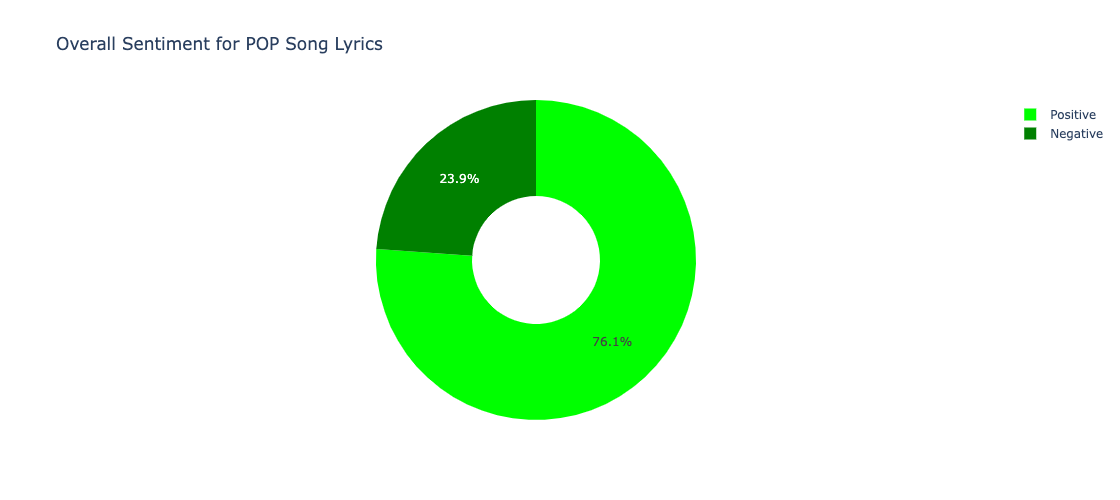

In [265]:
# import plotly.express as px
# Plot overall sentiment scores for genre

positives = result_lyrics_df['lyrics_sent'].loc[result_lyrics_df['lyrics_sent'] == 1 ].count()
negatives = result_lyrics_df['lyrics_sent'].loc[result_lyrics_df['lyrics_sent'] == -1 ].count()
index_names = ['Positive', 'Negative']

lyrics_sentiment = pd.DataFrame([positives,negatives], columns = ['Count'])
lyrics_sentiment.index = index_names

pop_sentiment_pie = px.pie(
    lyrics_sentiment, 
    values = 'Count', 
    names=index_names, 
    hole = 0.4, 
    color_discrete_sequence=["lime", "green"],
    width=1000, 
    height = 500,
    title='Overall Sentiment for POP Song Lyrics'
    )  
pop_sentiment_pie

In [266]:
# Describe lyrics sentiment
result_lyrics_df.describe()

,lyrics_compound,lyrics_pos,lyrics_neu,lyrics_neg,lyrics_sent
count,47.000000,47.000000,47.000000,47.000000,47.000000
mean,0.474749,0.173043,0.722255,0.104702,0.510638
std,0.783643,0.107479,0.135649,0.108968,0.856493
min,-0.999900,0.015000,0.300000,0.000000,-1.000000
25%,0.057950,0.090000,0.664000,0.039000,0.500000
50%,0.944500,0.140000,0.721000,0.081000,1.000000
75%,0.997550,0.246500,0.800500,0.124000,1.000000
max,0.999600,0.457000,0.985000,0.677000,1.000000


# NGrams and Frequency Analysis
In this section there are the ngrams and word frequency for lyrics.

Use NLTK to produce the n-grams

In [267]:
# Generate the Bitcoin N-grams where N=2
lyrics_text = ' '.join(new_lyrics_df["Lyrics"])
lyrics_processed = tokenizer(lyrics_text)
lyrics_ngrams = Counter(ngrams(lyrics_processed, n=2))
print(dict(lyrics_ngrams.most_common(80)))

{('low', 'low'): 151, ('yeah', 'yeah'): 85, ('thing', 'said'): 44, ('woman', 'woman'): 39, ('day', 'every'): 36, ('every', 'weekend'): 35, ('low', 'lololow'): 33, ('lololow', 'low'): 33, ('said', 'thing'): 29, ('safe', 'sound'): 27, ('lord', 'let'): 24, ('unstoppable', 'today'): 23, ('weekend', 'day'): 22, ('nah', 'nah'): 21, ('runnin', 'head'): 20, ('today', 'unstoppable'): 20, ('sound', 'safe'): 19, ('every', 'day'): 19, ('feel', 'like'): 18, ('middle', 'night'): 18, ('another', 'love'): 18, ('love', 'hurt'): 18, ('wide', 'awake'): 17, ('lie', 'lie'): 17, ('hurt', 'like'): 17, ('got', 'love'): 17, ('rolling', 'deep'): 16, ('title', 'title'): 16, ('let', 'say'): 16, ('say', 'lord'): 16, ('give', 'title'): 15, ('bad', 'habit'): 14, ('habit', 'lead'): 14, ('keep', 'wide'): 14, ('awake', 'every'): 14, ('low', 'woah'): 13, ('need', 'stay'): 12, ('head', 'runnin'): 12, ('gon', 'wish'): 12, ('wish', 'never'): 12, ('never', 'met'): 12, ('love', 'tear'): 12, ('tear', 'used'): 12, ('long', 'go

In [268]:
# Use the token_count function to generate the top 50 words from the lyrics
def token_count(Tokens, N=50):
    """Returns the top N tokens from the frequency count"""
    return Counter(Tokens).most_common(N)

In [269]:
# Use token_count to get the top 50 words from rnb lyrics
lyrics_top_50 = token_count(lyrics_processed)
lyrics_top_50

[('low', 200),
 ('yeah', 194),
 ('love', 179),
 ('know', 176),
 ('like', 166),
 ('got', 102),
 ('never', 95),
 ('baby', 93),
 ('need', 89),
 ('want', 83),
 ('let', 77),
 ('thing', 76),
 ('every', 70),
 ('feel', 67),
 ('say', 65),
 ('woman', 65),
 ('said', 64),
 ('way', 63),
 ('make', 62),
 ('night', 58),
 ('could', 53),
 ('time', 52),
 ('heart', 51),
 ('gon', 51),
 ('get', 51),
 ('day', 50),
 ('come', 49),
 ('see', 45),
 ('ooh', 43),
 ('really', 42),
 ('take', 41),
 ('alone', 39),
 ('weekend', 39),
 ('right', 38),
 ('nothing', 38),
 ('go', 37),
 ('dance', 36),
 ('give', 35),
 ('head', 35),
 ('lie', 33),
 ('safe', 33),
 ('lololow', 33),
 ('call', 32),
 ('title', 32),
 ('life', 31),
 ('think', 29),
 ('well', 29),
 ('tear', 29),
 ('ai', 28),
 ('sound', 28)]

In [270]:
# Create df for most common tokens

lyrics_top50_df = pd.DataFrame(lyrics_top_50, columns=['Word', 'Count']).set_index('Word')
lyrics_top50_df

,Count
Word,
low,200
yeah,194
love,179
know,176
like,166
got,102
never,95
baby,93
need,89


In [271]:
# Export Top Words dataframe to CSV
# lyrics_top50_df.to_csv('pop_top_words.csv')

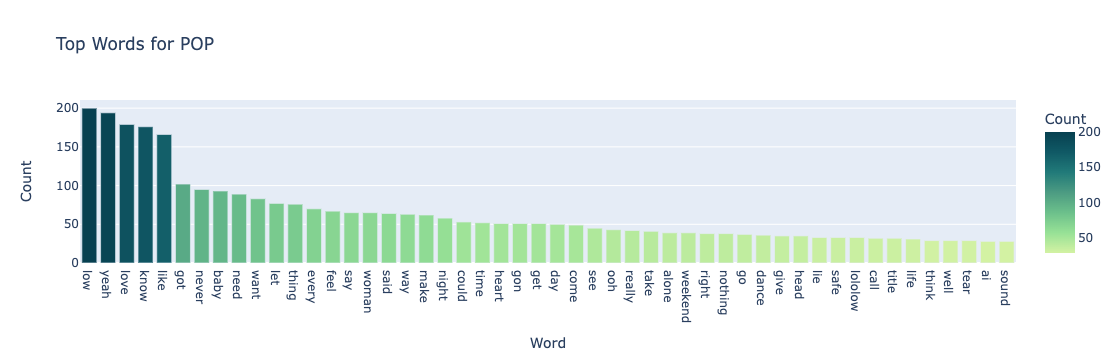

In [272]:
# Plot most common tokens
lyrics_top50_plot = px.bar(
    lyrics_top50_df,
    y = 'Count',
    color = "Count",
    color_continuous_scale='emrld',
    title ='Top Words for POP'
)
lyrics_top50_plot

# Word Clouds
In this section, I generate word clouds hip hop rap lyrics

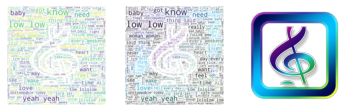

In [273]:
# Generate the RnB lyrics word cloud
lyrics_words_joined = ' '.join(lyrics_processed)

rnb_coloring = np.array(Image.open("Images/pop.png"))

wccc = WordCloud(background_color="white", max_words=2000, mask=rnb_coloring, max_font_size=120, random_state=42, width=2000, height=1200)

# generate word cloud
wccc.generate(lyrics_words_joined)

# create coloring from image
image_colors = ImageColorGenerator(rnb_coloring)

# show
fig, axes = plt.subplots(1, 3)
axes[0].imshow(wccc, interpolation="bilinear")
# recolor wordcloud and show
# we could also give color_func=image_colors directly in the constructor
axes[1].imshow(wccc.recolor(color_func=image_colors), interpolation="bilinear")
axes[2].imshow(rnb_coloring, cmap=plt.cm.gray, interpolation="bilinear")
for ax in axes:
    ax.set_axis_off()
plt.show()


In [274]:
# Save image as png
# wccc.to_file("Images/popwordcloud.png")

# Named Entity Recognition
In this section, we build a named entity recognition model for the hip hop lyrics, then visualize the tags using SpaCy.

In [275]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

In [276]:
# Run the NER processor on all of the text
rnb_ner = nlp(lyrics_text)

# Add a title to the document
rnb_ner.user_data['title'] = 'R&B Soul NER'

In [277]:
# Render the visualization
displacy.render(rnb_ner, style='ent')

In [278]:
# List all Entities
for ent in rnb_ner.ents:
    print(ent.text, ent.label_)

Til PERSON
Til PERSON
Til PERSON
Til PERSON
Shoorah PERSON
Baby PRODUCT
first ORDINAL
first ORDINAL
two days DATE
F-U PRODUCT
nah GPE
nah GPE
nah GPE
nah GPE
nah GPE
nah PERSON
F-U  You PRODUCT
F-U PRODUCT
nah GPE
nah GPE
nah GPE
nah GPE
nah GPE
nah PERSON
F-U Nah PRODUCT
nah GPE
nah GPE
nah GPE
nah GPE
nah GPE
nah PERSON
F-U PRODUCT
One CARDINAL
two CARDINAL
one CARDINAL
two CARDINAL
three CARDINAL
all day DATE
Ooh ORG
Mmh PERSON
all day DATE
Ooh ORG
Ooh ORG
One CARDINAL
two CARDINAL
three CARDINAL
four CARDINAL
tonight TIME
late nights DATE
Conversations PRODUCT
Swearin PERSON
two CARDINAL
Fallin ORG
first ORDINAL
late nights DATE
Conversations PRODUCT
Swearin PERSON
two CARDINAL
Burned ORG
late nights DATE
Conversations PRODUCT
Swearin PERSON
two CARDINAL
first ORDINAL
날아가 PERSON
first ORDINAL
first ORDINAL
시련도 결국엔 ORG
first ORDINAL
the middle of the night DATE
the middle of the night DATE
the middle of the night DATE
the middle of the night DATE
all night TIME
Til morning WORK_OF_A

In [279]:
# List all Entities

ent_labels=[]
entities=[]

for ent in rnb_ner.ents:
    ent_labels.append(ent.label_)
    entities.append(ent.text)

# Obtain frequency for each named entity

entities_freq = pd.DataFrame.from_dict([Counter(entities)]).T
entities_freq.columns = ['Frequency']
entities_freq.sort_values(by= 'Frequency', ascending=False, inplace = True)


# Retrieve labels for unique named entities

unique_nes = entities_freq.index.tolist()

labels = []

for word in unique_nes:
    idx = entities.index(word)
    label = ent_labels[idx]
    labels.append(label)

entities_freq['Label'] = labels

entities_freq

,Frequency,Label
tonight,25,TIME
every weekend,22,DATE
the middle of the night,18,DATE
nah,18,GPE
Baby,17,PRODUCT
...,...,...
Sugar Sugar,1,PERSON
ya Got,1,PERSON
3 a.m.,1,TIME
Gucci,1,PERSON


In [280]:
# Bar chart of frequencies of Named Entities

entities_count = pd.DataFrame.from_dict([Counter(ent_labels)]).T
entities_count.columns = ['Count']

entities_count.sort_values('Count',inplace=True, ascending=False)

entities_count.reset_index(inplace=True)
entities_count = entities_count.rename(columns = {'index':'Named_Entity'})

entities_count.head()

,Named_Entity,Count
0,DATE,100
1,PERSON,70
2,TIME,53
3,GPE,34
4,CARDINAL,30


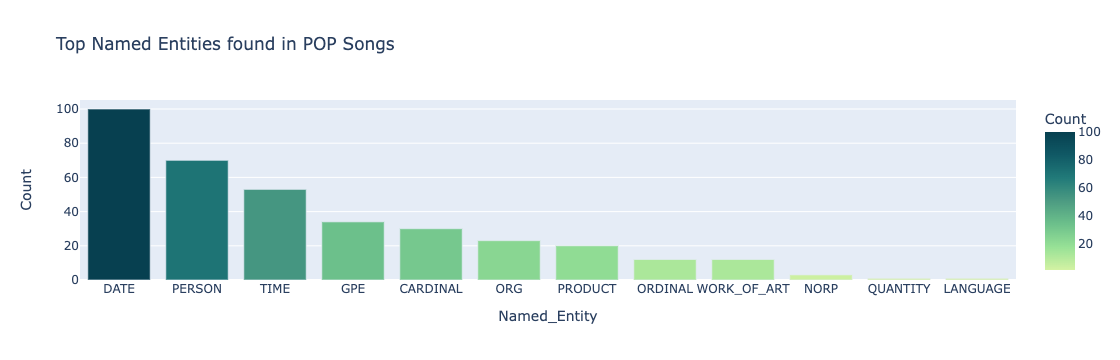

In [281]:
fig = px.bar(
    entities_count,
    x="Named_Entity",
    y="Count",
    color = "Count",
    color_continuous_scale='emrld',
    title = "Top Named Entities found in POP Songs"
     )
fig.show()

In [282]:
# Export Entities dataframe to CSV
# entities_count.to_csv('pop_entities_count.csv', index=False)

# Build a Markov Chain Function
We are going to build a simple Markov chain function that creates a dictionary:

- The keys should be all of the words in the corpus
- The values should be a list of the words that follow the keys

In [283]:
# from collections import defaultdict

def markov_chain(text):
    '''The input is a string of text and the output will be a dictionary with each word as
       a key and each value as the list of words that come after the key in the text.'''
    
    # Tokenize the text by word, though including punctuation
    words = text.split(' ')
#     for t in text:
#         words = t.split(' ')
#         print(words[0])
    
    # Initialize a default dictionary to hold all of the words and next words
    m_dict = defaultdict(list)
    
    # Create a zipped list of all of the word pairs and put them in word: list of next words format
    for current_word, next_word in zip(words[0:-1], words[1:]):
        m_dict[current_word].append(next_word)

    # Convert the default dict back into a dictionary
    m_dict = dict(m_dict)
    return m_dict

In [285]:
# Create the dictionary for lyrics, take a look at it

lyrics_dict = markov_chain(lyrics_text)

# Create a Text Generator
We're going to create a function that generates sentences. It will take two things as inputs:

- The dictionary you just created
- The number of words you want generated

In [291]:
# import random

def generate_sentence(chain, count=12):
    '''Input a dictionary in the format of key = current word, value = list of next words
       along with the number of words you would like to see in your generated sentence.'''

    # Capitalize the first word
    word1 = random.choice(list(chain.keys()))
    sentence = word1.capitalize()

    # Generate the second word from the value list. Set the new word as the first word. Repeat.
    for i in range(count-1):
        word2 = random.choice(chain[word1])
        word1 = word2
        sentence += ' ' + word2

    # End it with a period
    sentence += '.'
    return(sentence)

In [292]:
lines = []
line = []

num_sentences=32

with open('markov_pop.txt', 'w') as file:
    file.write('POP Song by Markov Chains')
    file.write('\n')
    file.write('------------------------------------------')
    file.write('\n')

    for num in range(0,num_sentences):
        line = generate_sentence(lyrics_dict)
        lines.append(line)
        file.write(line)
        file.write('\n')

In [222]:
line_1 = generate_sentence(lyrics_dict)
line_1

'Catch up, say But I see And it feels To.'

In [224]:
line_2 = generate_sentence(lyrics_dict)
line_2

"Sheets Have you think it's like this  Get the."

In [226]:
line_3 = generate_sentence(lyrics_dict)
line_3

"Saw you really got my rugged heart And I won't."

In [227]:
line_4 = generate_sentence(lyrics_dict)
line_4

"Open up my cornerstone You're my pride But I know."

In [228]:
chorus_1 = generate_sentence(lyrics_dict)
chorus_1

'Look mom! No hands!  Oh, oh-ooh-oh Oh, no, no).'

In [229]:
chorus_2 = generate_sentence(lyrics_dict)
chorus_2

'Ring? She says that I just gotta lie to you.'

In [230]:
chorus_3 = generate_sentence(lyrics_dict)
chorus_3

'Replace us, or the prototype like (like) I want you.'

In [231]:
chorus_4 = generate_sentence(lyrics_dict)
chorus_4

"Yeah, yeah, yeah, yeah  Maybe I'm wasted here Well."

In [232]:
line_5 = generate_sentence(lyrics_dict)
line_5

"Chest any more But you're doing great out by myself."

In [233]:
line_6 = generate_sentence(lyrics_dict)
line_6

"Your-) I was lookin' for help Your kisses burn into."

In [235]:
line_7 = generate_sentence(lyrics_dict)
line_7

"Them 'Cause this love me Ay, ay, leave us tainted."

In [236]:
line_8 = generate_sentence(lyrics_dict)
line_8

"Kids, but can't be borrowed I'd rather die than life)."

In [237]:
line_9 = generate_sentence(lyrics_dict)
line_9

"To be my rosemary goes down I can't follow my."

In [238]:
line_10 = generate_sentence(lyrics_dict)
line_10

"Walking  (Spin 'round in disbelief 'Cause it feels like."

# Create a hit song

In [239]:
# Pring the hit rnb song
print('The Pop Song')
print('_____________________________')
print('Verse 1')
print('_____________________________')
print(line_1)
print(line_2)
print(line_3)
print(line_4)
print('_____________________________')
print('Chorus')
print('_____________________________')
print(chorus_1)
print(chorus_2)
print(chorus_3)
print(chorus_4)
print('_____________________________')
print('Verse 2')
print('_____________________________')
print(line_5)
print(line_6)
print(line_7)
print(line_8)
print('_____________________________')
print('Bridge')
print('_____________________________')
print(line_9)
print(line_10)
print('_____________________________')
print('Chorus (Repeat X 3)')
print('_____________________________')
print(chorus_1)
print(chorus_2)
print(chorus_3)
print(chorus_4)

The Pop Song
_____________________________
Verse 1
_____________________________
Catch up, say But I see And it feels To.
Sheets Have you think it's like this  Get the.
Saw you really got my rugged heart And I won't.
Open up my cornerstone You're my pride But I know.
_____________________________
Chorus
_____________________________
Look mom! No hands!  Oh, oh-ooh-oh Oh, no, no).
Ring? She says that I just gotta lie to you.
Replace us, or the prototype like (like) I want you.
Yeah, yeah, yeah, yeah  Maybe I'm wasted here Well.
_____________________________
Verse 2
_____________________________
Chest any more But you're doing great out by myself.
Your-) I was lookin' for help Your kisses burn into.
Them 'Cause this love me Ay, ay, leave us tainted.
Kids, but can't be borrowed I'd rather die than life).
_____________________________
Bridge
_____________________________
To be my rosemary goes down I can't follow my.
Walking  (Spin 'round in disbelief 'Cause it feels like.
________________

In [240]:
# # Export a text file with the results
# with open('popsong.txt', 'w') as out:
#     out.write('The POP Song' '\n')
#     out.write('\n')
#     out.write('\n')
#     out.write('\n')
#     out.write('Verse 1')
#     out.write('\n')
#     out.write('\n')
#     out.write(line_1)
#     out.write('\n')
#     out.write(line_2)
#     out.write('\n')
#     out.write(line_3)
#     out.write('\n')
#     out.write(line_4)
#     out.write('\n')
#     out.write('\n')
#     out.write('Chorus')
#     out.write('\n')
#     out.write('\n')
#     out.write(chorus_1)
#     out.write('\n')
#     out.write(chorus_2)
#     out.write('\n')
#     out.write(chorus_3)
#     out.write('\n')
#     out.write(chorus_4)
#     out.write('\n')
#     out.write('\n')
#     out.write('Verse 2')
#     out.write('\n')
#     out.write('\n')
#     out.write(line_5)
#     out.write('\n')
#     out.write(line_6)
#     out.write('\n')
#     out.write(line_7)
#     out.write('\n')
#     out.write(line_8)
#     out.write('\n')
#     out.write('\n')
#     out.write('Chorus')
#     out.write('\n')
#     out.write('\n')
#     out.write(chorus_1)
#     out.write('\n')
#     out.write(chorus_2)
#     out.write('\n')
#     out.write(chorus_3)
#     out.write('\n')
#     out.write(chorus_4)
#     out.write('\n')
#     out.write('\n')
#     out.write('Bridge')
#     out.write('\n')
#     out.write('\n')
#     out.write(line_9)
#     out.write('\n')
#     out.write(line_10)
#     out.write('\n')
#     out.write('\n')
#     out.write('\n')
#     out.write('Chorus Repeat X 3')


In [241]:
# text = ' '.join(result_lyrics_df['Lyrics'].tolist())

# file = open('rnb_text.txt', 'w')
# file.write(text)

# Maximum Likelihood Estimator (MLE) Algorithm

Using Language Model Module (nltk.lm) from NLTK library

In [242]:
# Tokenize lyrics corpus
lyrics_corpus = list(new_lyrics_df['Lyrics'].apply(word_tokenize))

In [243]:
# Preprocess the tokenized text for 4-grams language modelling
n = 4
train_data, padded_sents = padded_everygram_pipeline(n, lyrics_corpus)

In [244]:
# Train and fit the model
rnb_model = MLE(n) # Lets train a 4-grams model
rnb_model.fit(train_data, padded_sents)

In [245]:
# Clean up the generated tokens to make it human-like.

detokenize = TreebankWordDetokenizer().detokenize

def generate_sent(model, num_words, random_seed):
    """
    :param model: An ngram language model from `nltk.lm.model`.
    :param num_words: Max no. of words to generate.
    :param random_seed: Seed value for random.
    """
    content = []
    for token in model.generate(num_words, random_seed=random_seed):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return detokenize(content)

In [246]:
# Predict text
mle_text = generate_sent(rnb_model, num_words=280, random_seed=128)
len(mle_text)  

# Note: pick a random seed that gives you 1000+ characters as the len(mle_text) 
# or run the generate_sent again until you hit your target size of lyrics

1143

In [247]:
# Save predicted lyrics as a .txt file

# with open('mle_pop.txt', 'w') as file:
#     file.write(mle_text)

# Save MLE Predicted Lyrics to Audio

In [248]:
from gtts import gTTS 
import os

In [250]:
speech = gTTS(text = mle_text, lang = 'en', slow = True)
speech.save("pop_mle_text.mp3")